# Capstone Project - Compatible Neighborhoods

## Introduction/Business Problem

The high growth in tech companies and the related job market has led to a large migration of professionals from all across America to tech hub cities wanting to take part in new opportunities.  The increase in population in these hub cities led to the exciting new openings of venues and other less desirable changes such as rising rents.  When considering to move to one of these cities, it can be difficult choosing between neighborhoods.  How does one consider a new neighborhood based on data before visiting it?  What information would be useful to help narrow down the choices?

In this project, I explore the use case of a subject living in a high tech hub city wanting to relocate to another one.
Two metropolitan cities are compared - Seattle and San Francisco.  The study provides a mapping of a neighborhood in one city to a similar one in the other by grouping them into clusters.  All neighborhoods within the same cluster are considered compatible.  Compatibility is based on how similarity of neighborhoods based on the types of popular venues present in the neighborhood.

Initial assumptions are:
<ol>
    <li>The subject wants to find a neighborhood that is similar their current one but in a different city.</li>
    <li>The subject is primarily concerned with the types of popular venues present in the neighborhood.</li>
    <li>The subject is impartial towards climate differences.</li>
    <li>The subject is impartial towards demographics of the city's residents.</li>
    <li>The subject is impartial towards differences in cost between the two cities.</li>
</ol>


## Data

To assess similarity, I will use many of the attributes gathered form Foursquare during the labs such as venue types and counts.  This will require API calls to Foursquare followed by conversion to Panda data frames.

Zip codes to boroughs and geo coordinates of boroughs will be gathered from wikipedia and/or google searches.  The format will likely be an html table or CSV which will be converted to data frames and then merged with the Foursquare data.

Boroughs will be clustered using the data gathered so far.

I would also like to consider the demographics of the borough - population density, mean age, total population, etc.  I plan to obtain these from the US Census Bureau.  The likely format will be CSV and they data will augment the analysis after the clustering has been done.

If time and APIs allow, I would like to consider the hours of operations and popular times for the most popular venues in the borough.  These require premium API calls, so I may not be able to collect the data, or the data will be limited.

### Data - Part 1 - Gather Neighborhood and Geocode Data

Note: Neighborhood data on Wikipedia appeared in different formats for each city on Wikipedia include non-tabular format which made scraping the data programatically difficult.  I manually parsed out the neighborhood data from the Wikipedia page and saved them to csv files.

As for geocoding, I found that the geocoder library never returns coordinates.  I looked into Google's geocoding APIs and found it requires a paid subscription.

As a workaround, I used google's online geocoder tool to manually gather the coordinates for each neighborhood into a csv format. https://www.mapdevelopers.com/geocode_tool.php

In many cases, the geocoder tool could not locate the neighborhood.  For these cases, I entered the neighborhood into https://maps.google.com and obtained the Lat/Long from the center of the neighborhood.


I want to compare the neighborhoods of Austin, San Francisco, and Seattle by gathering venue information from Foursquare.

Venue information consists of venue type and frequency of visits.  The frequency of visits will be normalized by dividing by the total frequency of all venues to allow consolidating all three city's venue information into a single data frame.

Getting list of neighborhoods from Wikipedia was a challenge.
Neighborhood data on Wikipedia appeared in different formats for each city on Wikipedia include non-tabular format which made scraping the data programatically difficult.  I manually parsed out the neighborhood data from the Wikipedia page and saved them to csv files.

List of URLs to wikipedia:<br/>
<ul>
<li>https://en.wikipedia.org/wiki/List_of_neighborhoods_in_San_Francisco</li>
<li>https://en.wikipedia.org/wiki/List_of_Austin_neighborhoods</li>
<li>https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle</li>
</ul>

As for geocoding, I found that the geocoder library never returns coordinates.  I looked into Google's geocoding APIs and found it requires a paid subscription.

As a workaround, I used google's online geocoder tool to manually gather the coordinates for each neighborhood into a csv format. https://www.mapdevelopers.com/geocode_tool.php

In [6]:
import pandas as pd

In [7]:
#!conda clean --index-cache

In [8]:
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [30]:
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ------------------------------------------------------------
                       

In [9]:
# List of cities and URLs at wiki for neighborhoods
CITY_NAMES = ['San Francisco, California', 'Seattle, Washington']
CITY_RADIUS = [1560, 2376] # in meters
CITY_ZOOM_START = [12, 11]
CITY_GEO_CSV_URL = ['https://raw.githubusercontent.com/echoi11/data-capstone/master/San_Francisco_Geo.csv', 'https://raw.githubusercontent.com/echoi11/data-capstone/master/Seattle_Geo.csv']
CITY_VENUE_CSV = ['https://raw.githubusercontent.com/echoi11/data-capstone/master/San_Francisco_Venues.csv', 'https://raw.githubusercontent.com/echoi11/data-capstone/master/Seattle_Venues.csv']

In [10]:
# function for loading neighborhoods and geos
def loadCityData(city_index) :
    df_neigh = pd.read_csv(CITY_GEO_CSV_URL[city_index])
    print('{} has {} neighborhoods.'.format(
        CITY_NAMES[city_index],
        df_neigh.shape[0]
    )
         )
    return df_neigh

In [11]:
# create map using latitude and longitude values
def mapOfCity(city_index, city_data) :
    address = CITY_NAMES[city_index]

    geolocator = Nominatim(user_agent="us_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

    map_city = folium.Map(location=[latitude, longitude], zoom_start=CITY_ZOOM_START[city_index])

    # add markers to map
    for lat, lng, neighborhood in zip(city_data['Latitude'], city_data['Longitude'], city_data['Neighborhood']):
        label = '{}'.format(neighborhood)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_city)  

    return map_city

In [12]:
# Load San Francisco city data and map it using folium
sf_city_data = loadCityData(0)
sf_map = mapOfCity(0, sf_city_data)
sf_map

San Francisco, California has 120 neighborhoods.


In [13]:
# Load Seattle city data and map it using folium
se_city_data = loadCityData(1)
se_map = mapOfCity(1, se_city_data)
se_map

Seattle, Washington has 124 neighborhoods.


### Data - Part 2 - Get Venue Data from Foursquare API

In [14]:
import requests

# TODO Hide
CLIENT_ID = 'BRC3YDAQCYI4A4KCDKO2FMWE0RXWQZYFGH13FBXIC3OL3DV3123' # your Foursquare ID
CLIENT_SECRET = 'ZX1EIGLU0HWZVRXBI54OM22WLPGTJYRFWSEZT4G5JMHBR1BB123' # your Foursquare Secret
VERSION = '20200414' # Foursquare API version
LIMIT = 100

In [18]:
# create a function to get venues for each neighborhood
def getNearbyVenues(city_index, city_data, load_from_csv):

    if load_from_csv :
        # load from csv
        print("Loading venues from csv ...")
        nearby_venues = pd.read_csv(CITY_VENUE_CSV[city_index])
        print("Loading venues from csv completed")
        return nearby_venues
    
    radius = CITY_RADIUS[city_index]
    names=city_data['Neighborhood']
    latitudes=city_data['Latitude']
    longitudes=city_data['Longitude']
            
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print("Getting venues for " + name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
# For creating a csv download of venue data in order to not exhaust Foursquare API quota.

from IPython.display import HTML
import base64

def create_download_link( df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)


In [113]:
#def venueCountByCity(cityName, venues):
#    print("City:" + cityName)
#    print(", venue count:" + venues.count())
#    return venues.count()

# check how many venues for each neighborhood
#def printVenueCountByNeighborhood(cityName, venues):
#    print("City:" + cityName + ", count:" + venues.groupby('Neighborhood').count())

### San Francisco Venue Data

In [17]:
sf_city_venues = getNearbyVenues(0, sf_city_data, True)
sf_city_venues.head()

Loading venues from csv


Unnamed: 0  Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0           0  Alamo Square               37.77636             -122.434688   
1           1  Alamo Square               37.77636             -122.434688   
2           2  Alamo Square               37.77636             -122.434688   
3           3  Alamo Square               37.77636             -122.434688   
4           4  Alamo Square               37.77636             -122.434688   

                   Venue  Venue Latitude  Venue Longitude Venue Category  
0           Alamo Square       37.776045      -122.434363           Park  
1  Alamo Square Dog Park       37.775878      -122.435740        Dog Run  
2         Painted Ladies       37.776120      -122.433389  Historic Site  
3        The Independent       37.775573      -122.437835      Rock Club  
4          Fool’s Errand       37.775512      -122.437961            Bar

In [42]:
create_download_link(sf_city_venues)

### Seattle Venue Data

In [19]:
se_city_venues = getNearbyVenues(1, se_city_data, True)
se_city_venues.head()

Loading venues from csv
Loading venues from csv completed


Unnamed: 0 Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0           0        Adams              47.670575             -122.387093   
1           1        Adams              47.670575             -122.387093   
2           2        Adams              47.670575             -122.387093   
3           3        Adams              47.670575             -122.387093   
4           4        Adams              47.670575             -122.387093   

                     Venue  Venue Latitude  Venue Longitude  \
0              Cafe Besalu       47.671971      -122.387755   
1         8oz Burger & Co.       47.668601      -122.388192   
2             Salt & Straw       47.668210      -122.385534   
3       La Carta De Oaxaca       47.668169      -122.385767   
4  Ballard Farmer's Market       47.667466      -122.384316   

       Venue Category  
0              Bakery  
1        Burger Joint  
2      Ice Cream Shop  
3  Mexican Restaurant  
4      Farmers Market

In [116]:
create_download_link(se_city_venues)

## Methodology - Explore and Cluster Neighborhoods for Each City</h2>

KMeans will be run on the consolidated city information so that similar neighborhoods in different cities can potentially be grouped into the same cluster.
Neighborhoods in the same cluster will be considered similar or compatible neighborhoods.

### Analyze Each Neighborhood

In [20]:
import numpy as np

def oneHotCategoryGroupByNeighborhood(city_venues):
    # one hot encoding
    city_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    city_onehot['Neighborhood'] = city_venues['Neighborhood'] 

    # move neighborhood column to the first column
    fixed_columns = [city_onehot.columns[-1]] + list(city_onehot.columns[:-1])
    city_onehot = city_onehot[fixed_columns]

    return city_onehot

def oneHotGroupByNeighborhood(city_onehot):
    city_grouped = city_onehot.groupby('Neighborhood').mean().reset_index()
    return city_grouped

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

def appendMostCommonVenueColumns(city_grouped) :
    num_top_venues = 10

    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted['Neighborhood'] = city_grouped['Neighborhood']

    for ind in np.arange(city_grouped.shape[0]):
        neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)

    return neighborhoods_venues_sorted


### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

city_grouped = city_onehot.groupby('Neighborhood').mean().reset_index()
city_grouped

Print each neighborhood with the top 5 most common venues

In [ ]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
# put data into df



Now let's create the new dataframe and display the top 10 venues for each neighborhood.

#### Map of San Francisco with neighborhoods superimposed

## Methodology

### Part 1 - Cluster Neighborhoods

In [21]:
import numpy as np
from sklearn.cluster import KMeans

def runKMeans(city_grouped, kclusters=5):

    city_grouped_clustering = city_grouped.drop('Neighborhood', 1)

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)

    # check cluster labels generated for each row in the dataframe
    kmeans.labels_[0:10]
    
    return kmeans

In [22]:
def mergeKMeansToCityData(city_data, city_grouped_data, kmeans):
    
    neighborhoods_venues_sorted = appendMostCommonVenueColumns(city_grouped_data)
    
    # add clustering labels
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

    city_merged = city_data

    # merge city_grouped with city_data to add latitude/longitude for each neighborhood
    city_merged = city_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

    city_merged.sort_values('Cluster Labels')
    
    city_merged # check the last columns!
    
    print(city_merged)
    
    return city_merged

In [23]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

def mapOfClusters(city_index, city_data, kclusters) :
    
    address = CITY_NAMES[city_index]

    geolocator = Nominatim(user_agent="us_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

    map_city = folium.Map(location=[latitude, longitude], zoom_start=CITY_ZOOM_START[city_index])

    # create map to visualize the clusters
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=CITY_ZOOM_START[city_index])

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(city_data['Latitude'], city_data['Longitude'], city_data['Neighborhood'], city_data['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)

    return map_clusters

toronto_merged.sort_values('Cluster Labels')

In [24]:
# combine venue data from both cities
all_city_data = pd.concat([sf_city_data, se_city_data], ignore_index=True).drop(['Borough', 'Row'], axis=1)
all_city_data


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


Latitude   Longitude                      Neighborhood
0    37.776360 -122.434689                      Alamo Square
1    37.780836 -122.443149                        Anza Vista
2    37.765442 -122.445360                   Ashbury Heights
3    37.721427 -122.447547                       Balboa Park
4    37.731524 -122.468539                    Balboa Terrace
5    37.728889 -122.392500                           Bayview
6    37.728889 -122.403886                      Belden Place
7    37.742986 -122.415804                    Bernal Heights
8    37.806532 -122.420649                       Buena Vista
9    37.744567 -122.395353                       Butchertown
10   37.760856 -122.434957                            Castro
11   37.784378 -122.424528                    Cathedral Hill
12   37.724859 -122.440086                    Cayuga Terrace
13   37.776329 -122.391839                       China Basin
14   37.794301 -122.406376                         Chinatown
15   37.779594 -122.416794                      Civic Center
16   37.758575 -122.451367                 Clarendon Heights
17   37.765813 -122.449962                       Cole Valley
18   37.762060 -122.443297                    Corona Heights
19   37.797262 -122.436248                        Cow Hollow
20   37.709378 -122.438587                    Crocker-Amazon
21   37.768169 -122.398620                   Design District
22   37.761894 -122.437299                   Diamond Heights
23   37.757394 -122.389903                          Dogpatch
24   37.757358 -122.433331                   Dolores Heights
25   37.767138 -122.432230                   Duboce Triangle
26   37.792864 -122.396912                       Embarcadero
27   37.758522 -122.441183                     Eureka Valley
28   37.724265 -122.427641                         Excelsior
29   37.780860 -122.425420                          Fillmore
..         ...         ...                               ...
214  47.640452 -122.292709                       Renton Hill
215  47.544537 -122.352558                         Riverview
216  47.680048 -122.314132                         Roosevelt
217  47.526624 -122.370331                           Roxhill
218  47.680291 -122.254225                        Sand Point
219  47.555911 -122.396191           Seaview / Mee-Kwa-Mooks
220  47.549434 -122.257738                       Seward Park
221  47.584674 -122.334928                              SoDo
222  47.531595 -122.288742    South Beacon Hill / Van Asselt
223  47.526852 -122.360448                    South Delridge
224  47.639919 -122.335465         South Lake Union, Seattle
225  47.526615 -122.323628               South Park, Seattle
226  47.641360 -122.392577                Southeast Magnolia
227  47.625815 -122.304001                           Stevens
228  47.680375 -122.400502                       Sunset Hill
229  47.654324 -122.308009  University District (U District)
230  47.663459 -122.298558                University Village
231  47.710496 -122.305927                   Victory Heights
232  47.682562 -122.274034                        View Ridge
233  47.659463 -122.334342                       Wallingford
234  47.627313 -122.287511                   Washington Park
235  47.690253 -122.290811                          Wedgwood
236  47.607270 -122.336949                         West Edge
237  47.634393 -122.366784                   West Queen Anne
238  47.571034 -122.386665                      West Seattle
239  47.669223 -122.368534                     West Woodland
240  47.632385 -122.342558                          Westlake
241  47.683297 -122.371449                  Whittier Heights
242  47.670553 -122.267017                        Windermere
243  47.602925 -122.321136                    Yesler Terrace

[244 rows x 3 columns]

In [25]:
all_city_venues = pd.concat([sf_city_venues, se_city_venues])
all_city_venues

Unnamed: 0    Neighborhood  Neighborhood Latitude  \
0               0    Alamo Square              37.776360   
1               1    Alamo Square              37.776360   
2               2    Alamo Square              37.776360   
3               3    Alamo Square              37.776360   
4               4    Alamo Square              37.776360   
5               5    Alamo Square              37.776360   
6               6    Alamo Square              37.776360   
7               7    Alamo Square              37.776360   
8               8    Alamo Square              37.776360   
9               9    Alamo Square              37.776360   
10             10    Alamo Square              37.776360   
11             11    Alamo Square              37.776360   
12             12    Alamo Square              37.776360   
13             13    Alamo Square              37.776360   
14             14    Alamo Square              37.776360   
15             15    Alamo Square              37.776360   
16             16    Alamo Square              37.776360   
17             17    Alamo Square              37.776360   
18             18    Alamo Square              37.776360   
19             19    Alamo Square              37.776360   
20             20    Alamo Square              37.776360   
21             21    Alamo Square              37.776360   
22             22    Alamo Square              37.776360   
23             23    Alamo Square              37.776360   
24             24    Alamo Square              37.776360   
25             25    Alamo Square              37.776360   
26             26    Alamo Square              37.776360   
27             27    Alamo Square              37.776360   
28             28    Alamo Square              37.776360   
29             29    Alamo Square              37.776360   
...           ...             ...                    ...   
11882       11882  Yesler Terrace              47.602925   
11883       11883  Yesler Terrace              47.602925   
11884       11884  Yesler Terrace              47.602925   
11885       11885  Yesler Terrace              47.602925   
11886       11886  Yesler Terrace              47.602925   
11887       11887  Yesler Terrace              47.602925   
11888       11888  Yesler Terrace              47.602925   
11889       11889  Yesler Terrace              47.602925   
11890       11890  Yesler Terrace              47.602925   
11891       11891  Yesler Terrace              47.602925   
11892       11892  Yesler Terrace              47.602925   
11893       11893  Yesler Terrace              47.602925   
11894       11894  Yesler Terrace              47.602925   
11895       11895  Yesler Terrace              47.602925   
11896       11896  Yesler Terrace              47.602925   
11897       11897  Yesler Terrace              47.602925   
11898       11898  Yesler Terrace              47.602925   
11899       11899  Yesler Terrace              47.602925   
11900       11900  Yesler Terrace              47.602925   
11901       11901  Yesler Terrace              47.602925   
11902       11902  Yesler Terrace              47.602925   
11903       11903  Yesler Terrace              47.602925   
11904       11904  Yesler Terrace              47.602925   
11905       11905  Yesler Terrace              47.602925   
11906       11906  Yesler Terrace              47.602925   
11907       11907  Yesler Terrace              47.602925   
11908       11908  Yesler Terrace              47.602925   
11909       11909  Yesler Terrace              47.602925   
11910       11910  Yesler Terrace              47.602925   
11911       11911  Yesler Terrace              47.602925   

       Neighborhood Longitude                                          Venue  \
0                 -122.434688                                   Alamo Square   
1                 -122.434688                          Alamo Square Dog Park   
2                 -122.434688                 

In [26]:
all_city_onehot = oneHotCategoryGroupByNeighborhood(all_city_venues)
all_city_grouped = oneHotGroupByNeighborhood(all_city_onehot)
all_city_grouped

Neighborhood  Zoo Exhibit       ATM  Acai House  \
0                               Adams     0.000000  0.000000        0.00   
1                        Alamo Square     0.000000  0.000000        0.00   
2                          Alki Point     0.000000  0.000000        0.00   
3                          Anza Vista     0.000000  0.000000        0.00   
4                       Arbor Heights     0.000000  0.010101        0.00   
5                     Ashbury Heights     0.000000  0.000000        0.00   
6                            Atlantic     0.000000  0.000000        0.00   
7                         Balboa Park     0.000000  0.000000        0.00   
8                      Balboa Terrace     0.000000  0.000000        0.00   
9                             Ballard     0.000000  0.000000        0.00   
10                            Bayview     0.000000  0.000000        0.00   
11                        Beacon Hill     0.000000  0.000000        0.00   
12                       Belden Place     0.000000  0.000000        0.00   
13                           Belltown     0.000000  0.000000        0.00   
14                     Bernal Heights     0.000000  0.000000        0.00   
15                        Bitter Lake     0.000000  0.022472        0.00   
16                         Briarcliff     0.000000  0.015152        0.00   
17                           Brighton     0.000000  0.000000        0.00   
18                          Broadmoor     0.000000  0.000000        0.00   
19                          Broadview     0.000000  0.012346        0.00   
20                           Broadway     0.000000  0.000000        0.00   
21                             Bryant     0.000000  0.000000        0.00   
22                        Buena Vista     0.010000  0.000000        0.00   
23                        Butchertown     0.000000  0.000000        0.00   
24                       Capitol Hill     0.000000  0.000000        0.00   
25                   Cascade, Seattle     0.000000  0.000000        0.00   
26                             Castro     0.000000  0.000000        0.00   
27                     Cathedral Hill     0.000000  0.000000        0.00   
28                     Cayuga Terrace     0.000000  0.000000        0.00   
29                         Cedar Park     0.000000  0.000000        0.00   
..                                ...          ...       ...         ...   
214                       Sunset Hill     0.000000  0.000000        0.00   
215                    Telegraph Hill     0.000000  0.000000        0.01   
216                        Tenderloin     0.000000  0.000000        0.00   
217                   Treasure Island     0.000000  0.000000        0.00   
218                        Twin Peaks     0.000000  0.000000        0.00   
219                      Union Square     0.000000  0.000000        0.00   
220  University District (U District)     0.000000  0.000000        0.00   
221                  University Mound     0.000000  0.000000        0.00   
222                University Village     0.000000  0.000000        0.00   
223                      Upper Market     0.000000  0.000000        0.00   
224                   Victory Heights     0.000000  0.000000        0.00   
225                        View Ridge     0.000000  0.010870        0.00   
226                 Visitacion Valley     0.000000  0.000000        0.00   
227                     Vista del Mar     0.016393  0.000000        0.00   
228                       Wallingford     0.000000  0.000000        0.00   
229                   Washington Park     0.000000  0.000000        0.00   
230                          Wedgwood     0.000000  0.010000        0.00   
231                         West Edge     0.000000  0.000000        0.00   
232                       West Portal     0.000000  0.000000        0.00   
233                   West Queen Anne     0.000000  0.010000        0.00   
234                      West Seattle     0.000000  0.000000        0.00 

In [27]:
# TODO try different clusters
kmeans = runKMeans(all_city_grouped, 5)


In [28]:
all_city_merged = mergeKMeansToCityData(all_city_data, all_city_grouped, kmeans)


      Latitude   Longitude                      Neighborhood  Cluster Labels  \
0    37.776360 -122.434689                      Alamo Square               0   
1    37.780836 -122.443149                        Anza Vista               0   
2    37.765442 -122.445360                   Ashbury Heights               3   
3    37.721427 -122.447547                       Balboa Park               2   
4    37.731524 -122.468539                    Balboa Terrace               2   
5    37.728889 -122.392500                           Bayview               2   
6    37.728889 -122.403886                      Belden Place               2   
7    37.742986 -122.415804                    Bernal Heights               0   
8    37.806532 -122.420649                       Buena Vista               3   
9    37.744567 -122.395353                       Butchertown               0   
10   37.760856 -122.434957                            Castro               0   
11   37.784378 -122.424528              

In [29]:
create_download_link(all_city_merged)
#todo group by clusters and print out the neighborhoods of each cluster.

In [144]:
sf_cluster_map = mapOfClusters(0, all_city_merged, 5)
sf_cluster_map

The geograpical coordinate of San Francisco, California are 37.7790262, -122.4199061.


In [ ]:
se_cluster_map = mapOfClusters(1, all_city_merged)
se_cluster_map

# Examine Clusters

In [93]:
# print out each cluster
for i in range(0, 5) :
    print('==========================================================================')
    print('Cluster ', i)
    print(all_city_merged.loc[all_city_merged['Cluster Labels'] == i, all_city_merged.columns[[1] + list(range(5, all_city_merged.shape[1]))]])

Cluster  0
                         Neighborhood  Cluster Labels  Zoo Exhibit   ATM  \
0                               Adams             0.0         0.00  0.00   
4                             Ballard             0.0         0.00  0.00   
13                             Bryant             0.0         0.00  0.00   
14                       Capitol Hill             0.0         0.00  0.00   
27                    East Queen Anne             0.0         0.00  0.00   
28                           Eastlake             0.0         0.00  0.00   
32                            Fremont             0.0         0.01  0.00   
36                         Green Lake             0.0         0.01  0.00   
41                    Hawthorne Hills             0.0         0.00  0.00   
47                           Interbay             0.0         0.00  0.00   
48                         Interlaken             0.0         0.00  0.00   
53                         Lake Union             0.0         0.00  0.00   
5

In [ ]:
## Create a word cloud for each cluster

In [ ]:
## Try giving more weight most popular using f(x) = 1/x, where x is ranking

In [32]:
#word_cloud_df = all_city_merged.drop(['Latitude', 'Longitude', 'Neighborhood'], axis=1)
#word_cloud_df

Cluster Labels  1st Most Common Venue  2nd Most Common Venue  \
0                 0            Coffee Shop                   Park   
1                 0                   Café       Sushi Restaurant   
2                 3                   Park            Coffee Shop   
3                 2  Vietnamese Restaurant            Coffee Shop   
4                 2                 Bakery     Chinese Restaurant   
5                 2            Coffee Shop     Chinese Restaurant   
6                 2                 Bakery     Chinese Restaurant   
7                 0     Mexican Restaurant            Coffee Shop   
8                 3                   Park            Pizza Place   
9                 0            Coffee Shop                   Park   
10                0                   Park            Coffee Shop   
11                0            Coffee Shop         Ice Cream Shop   
12                2            Coffee Shop                   Park   
13                4            Coffee Shop            Pizza Place   
14                4                  Hotel            Pizza Place   
15                4            Coffee Shop         Sandwich Place   
16                3                   Park            Coffee Shop   
17                3                   Park            Coffee Shop   
18                3                   Park            Coffee Shop   
19                3                   Park            Coffee Shop   
20                2            Pizza Place             Playground   
21                0            Coffee Shop                   Park   
22                0            Coffee Shop                   Park   
23                0            Coffee Shop            Art Gallery   
24                0            Coffee Shop                 Bakery   
25                0            Coffee Shop                   Park   
26                4            Coffee Shop             Food Truck   
27                3                   Park         Scenic Lookout   
28                2                   Park            Pizza Place   
29                0            Coffee Shop                   Park   
..              ...                    ...                    ...   
214               3                   Park                 Garden   
215               1            Coffee Shop            Gas Station   
216               0            Coffee Shop                   Park   
217               1            Coffee Shop            Pizza Place   
218               3                   Park                Dog Run   
219               1            Coffee Shop            Pizza Place   
220               1  Vietnamese Restaurant                   Park   
221               1            Coffee Shop  Vietnamese Restaurant   
222               1  Vietnamese Restaurant     Mexican Restaurant   
223               1            Coffee Shop            Pizza Place   
224               0            Coffee Shop                   Park   
225               1                Airport       Airport Terminal   
226               2                   Park            Coffee Shop   
227               0            Coffee Shop     Italian Restaurant   
228               0            Coffee Shop           Cocktail Bar   
229               0                   Café     Seafood Restaurant   
230               0          Grocery Store            Pizza Place   
231               1            Coffee Shop         Sandwich Place   
232               3                   Park            Coffee Shop   
233               0                   Park            Coffee Shop   
234               0            Coffee Shop                 Bakery   
235               1            Coffee Shop                   Park   
236               4            Coffee Shop                  Hotel   
237               0                   Park            Coffee Shop   
238               1            Coffee Shop            Pizza Place   
239               0                Brewery           Cocktail Bar   
240

In [116]:
my_df = pd.DataFrame(columns=['Cluster Labels'])
for i in range(0, 10) :
    words = all_city_merged.iloc[:, [3, i+4]]
    words.columns = ['Cluster Labels','Word']
    my_df = pd.concat([my_df, words], sort=True)
    for j in range(0, int(10/(i+1))) :
         my_df = pd.concat([my_df, words], sort=True)

#my_df
#my_df.tail()
my_df.count()

Cluster Labels    9028
Word              9028
dtype: int64

In [223]:
#!conda install -c conda-forge wordcloud
from wordcloud import WordCloud, STOPWORDS
import numpy as npy
import matplotlib.pyplot as plt

def getClusterWordCounts(my_df, cluster_label):
    dataset = my_df[my_df['Cluster Labels']==cluster_label].iloc[ : , 1]
    return dataset.value_counts().to_dict()

def getWordCloud(word_counts):
    return WordCloud(width = 900, height = 900, 
                    background_color ='white', 
#                    stopwords = stopwords, 
                    min_font_size = 10).generate_from_frequencies(word_counts) 

def showWordCloud(my_df):
    stopwords = set(STOPWORDS)
    num_of_clusters = 5
    wordcloud = [None] * num_of_clusters
    
    fig = plt.figure(figsize = (14 * 2, 18 * ((num_of_clusters /2) + 1)))
#    plt.figure(figsize = (6, 20), facecolor = None) 
#        ax.figure(figsize = (10, 10), facecolor = None) 
    for i in range(0, num_of_clusters):
        word_counts = getClusterWordCounts(my_df, i)
        wordcloud[i] = getWordCloud(word_counts)
        
        ax = fig.add_subplot(num_of_clusters, 2, i + 1)
        ax.title.set_text('Cluster {}'.format(i))
        ax.title.set_fontsize(20)
        #ax.plot()
        ax.imshow(wordcloud[i], interpolation='nearest', aspect='auto') 
        ax.axis("off") 
        #plt.tight_layout(pad = 0)     
    
    plt.show() 

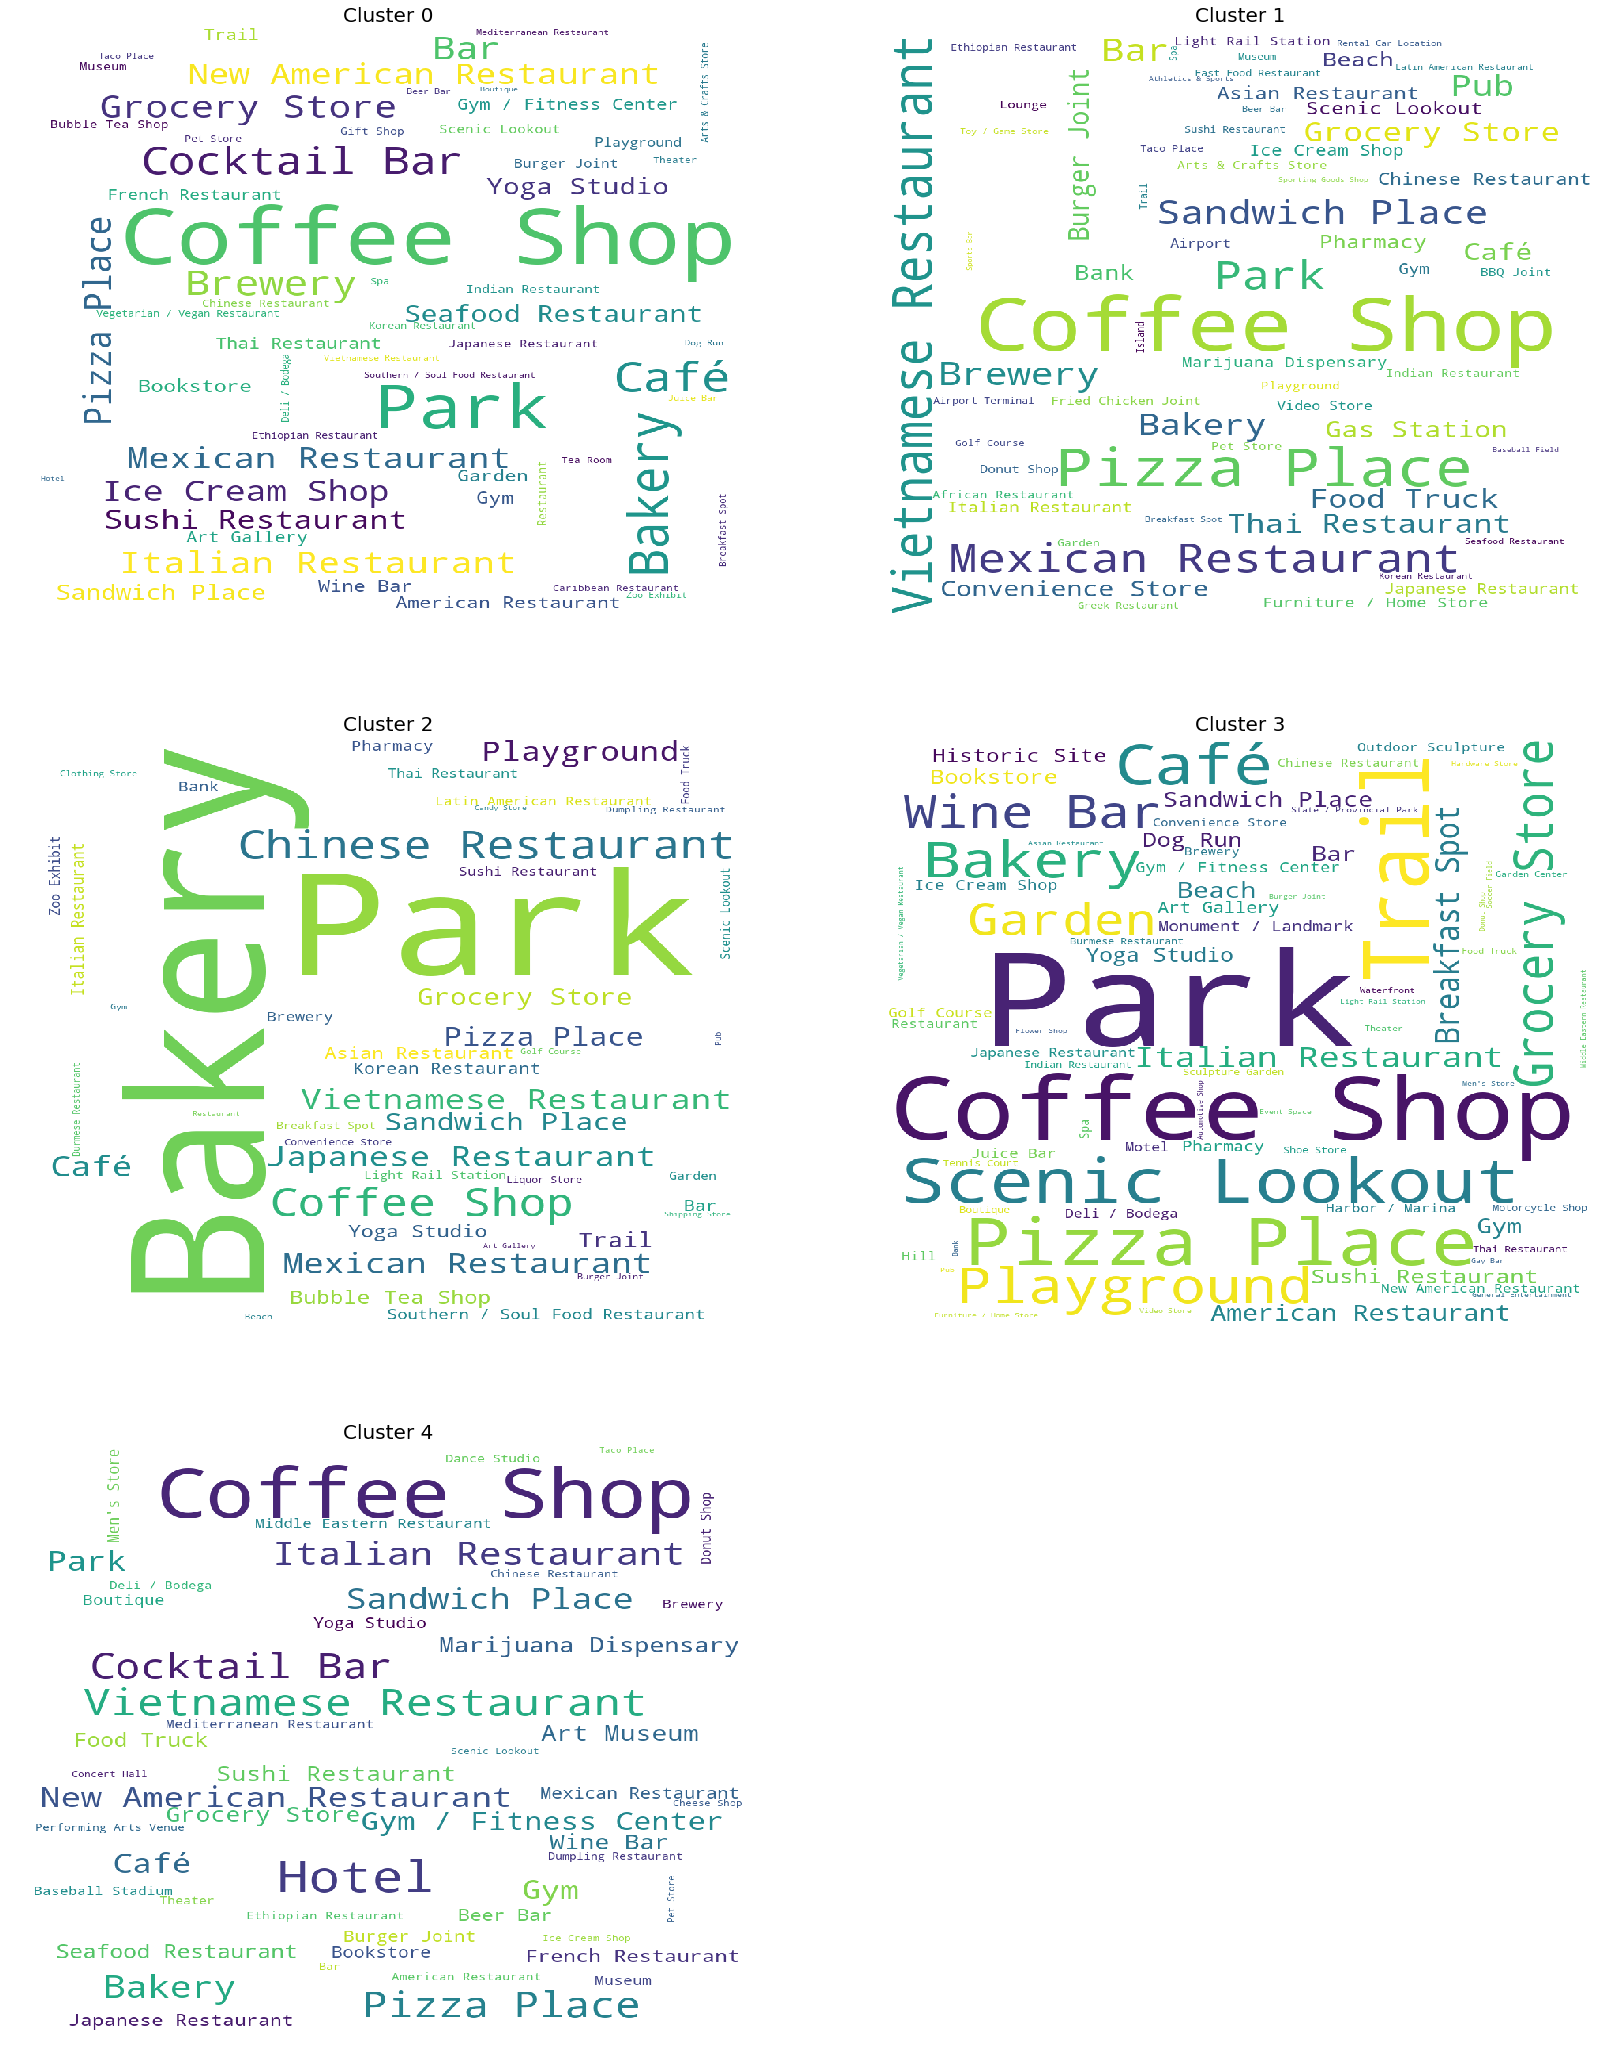

In [224]:
showWordCloud(my_df)

## Summary
#### Cluster 0 has the most neighborhoods and popular for cafes and restaurants.
#### Cluster 1 thru 4 have few neighborhoods and more popular for parks, trails and playgrounds.